In [40]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [42]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [43]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [44]:
tf.keras.backend.clear_session()

In [45]:
subject = 'Alagoas - Consumo de Cimento (t)'
start_index = 0
split_index = 179 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 12

In [46]:
data = pd.read_csv('2003_mo_model_input_AL.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Alagoas - IDH,Alagoas - Consumo de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Alagoas - value,Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado
0,2003-1,0.635160,30.109,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.294434,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07
1,2003-2,0.635571,27.684,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.296211,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07
2,2003-3,0.635982,26.534,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.297521,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07
3,2003-4,0.636393,25.109,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.298766,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07
4,2003-5,0.636804,25.171,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.299945,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,46.546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587645,NaN,24.556360,NaN,NaN,NaN,NaN
236,2022-9,NaN,47.781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587084,NaN,24.501314,NaN,NaN,NaN,NaN
237,2022-10,NaN,51.171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.585891,NaN,24.609100,NaN,NaN,NaN,NaN
238,2022-11,NaN,49.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584366,NaN,24.538488,NaN,NaN,NaN,NaN


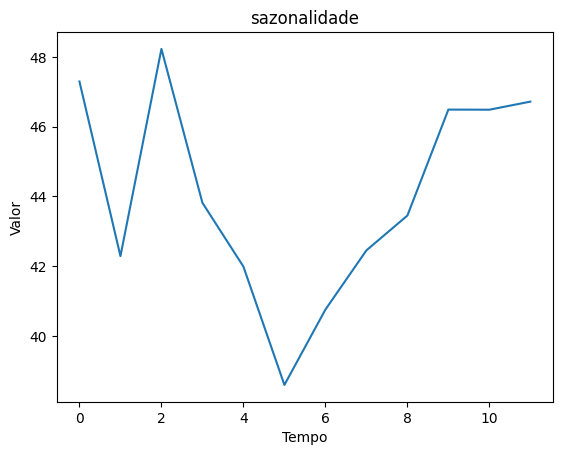

,sazonalidade
sazonalidade,
0,47.293071
1,42.292571
2,48.226679
3,43.819429
4,41.992714
5,38.603357
6,40.760714
7,42.456786
8,43.454071


In [47]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [48]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Alagoas - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Alagoas - value,Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,sazonalidade,Alagoas - Consumo de Cimento (t)
0,2003-1,0.635160,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.294434,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07,47.293071,30.109
1,2003-2,0.635571,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.296211,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07,42.292571,27.684
2,2003-3,0.635982,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.297521,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07,48.226679,26.534
3,2003-4,0.636393,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.298766,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07,43.819429,25.109
4,2003-5,0.636804,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.299945,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07,41.992714,25.171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587645,NaN,24.556360,NaN,NaN,NaN,NaN,42.456786,46.546
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587084,NaN,24.501314,NaN,NaN,NaN,NaN,43.454071,47.781
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.585891,NaN,24.609100,NaN,NaN,NaN,NaN,46.489000,51.171
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584366,NaN,24.538488,NaN,NaN,NaN,NaN,46.485786,49.126


In [49]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      29.095
1      25.241
2      29.040
3      25.685
4      21.197
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Alagoas - Consumo de Cimento (t), Length: 240, dtype: float64

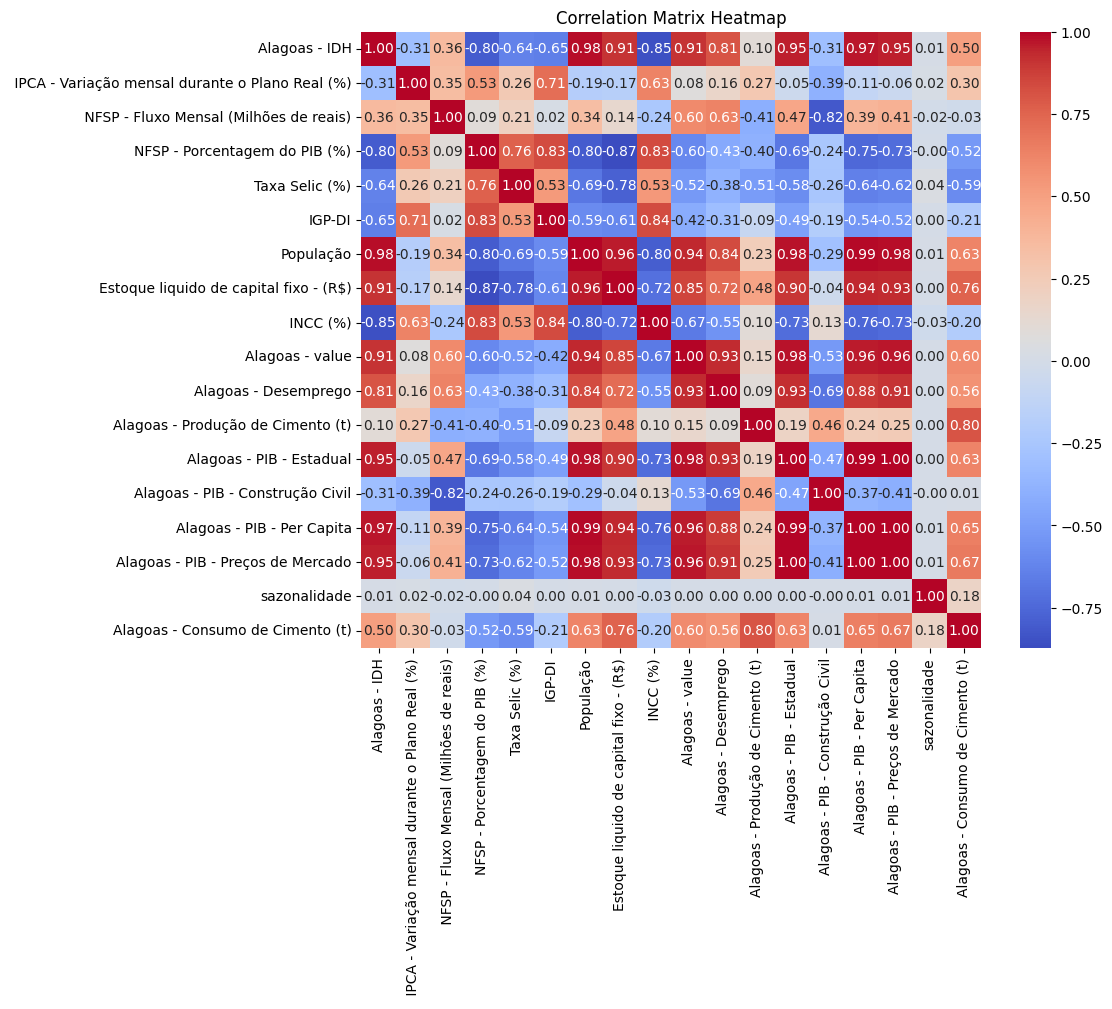

In [50]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [52]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Alagoas - IDH,7.550966e+05
1,IPCA - Variação mensal durante o Plano Real (%),3.122354e+03
2,NFSP - Fluxo Mensal (Milhões de reais),2.381971e+02
3,NFSP - Porcentagem do PIB (%),2.016593e+02
4,Taxa Selic (%),6.093730e+01
5,IGP-DI,3.167419e+02
6,População,4.359187e+06
7,Estoque liquido de capital fixo - (R$),5.841407e+06
8,INCC (%),1.075216e+03
9,Alagoas - value,2.230002e+04


In [53]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 1


,Alagoas - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Alagoas - value,Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Preços de Mercado,sazonalidade
0,0.635160,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.294434,8.765721,30.779440,2.590528e+07,1.303625e+06,2.359888e+07,47.293071
1,0.635571,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.296211,8.760196,30.599132,2.593685e+07,1.305020e+06,2.360861e+07,42.292571
2,0.635982,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.297521,8.754671,30.545910,2.596843e+07,1.306414e+06,2.361833e+07,48.226679
3,0.636393,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.298766,8.749145,30.377624,2.600000e+07,1.307809e+06,2.362806e+07,43.819429
4,0.636804,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.299945,8.743620,30.464900,2.603157e+07,1.309203e+06,2.363779e+07,41.992714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.677815,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,0.461941,14.206051,18.851408,3.132383e+07,1.302192e+06,2.473787e+07,42.456786
176,0.677806,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,0.461419,14.185836,18.955692,3.131883e+07,1.302193e+06,2.473537e+07,43.454071
177,0.677797,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,0.460904,14.165621,19.215115,3.131384e+07,1.302194e+06,2.473287e+07,46.489000
178,0.677789,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,0.460399,14.145406,19.366415,3.130884e+07,1.302196e+06,2.473036e+07,46.485786


In [54]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Alagoas - value,Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Preços de Mercado
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.337454,-0.812041,-1.061156,-1.592372,-1.418085,-1.799030
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.311262,-0.814085,-1.076377,-1.575265,-1.361111,-1.773385
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.291945,-0.816130,-1.080869,-1.558158,-1.304137,-1.747741
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.273580,-0.818175,-1.095074,-1.541051,-1.247164,-1.722096
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.256204,-0.820219,-1.087707,-1.523944,-1.190190,-1.696452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,1.132403,1.201260,-2.068023,1.343655,-1.476659,1.203662
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,1.124698,1.193779,-2.059221,1.340948,-1.476604,1.197061
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,1.117107,1.186298,-2.037322,1.338241,-1.476550,1.190460
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,1.109659,1.178817,-2.024551,1.335535,-1.476495,1.183859


In [55]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Alagoas - value,Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Preços de Mercado
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.337454,-0.812041,-1.061156,-1.592372,-1.418085,-1.799030
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.311262,-0.814085,-1.076377,-1.575265,-1.361111,-1.773385
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.291945,-0.816130,-1.080869,-1.558158,-1.304137,-1.747741
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.273580,-0.818175,-1.095074,-1.541051,-1.247164,-1.722096
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.256204,-0.820219,-1.087707,-1.523944,-1.190190,-1.696452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,1.294402,1.319787,-1.365958,1.343121,-1.394938,1.236790
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,1.275704,1.306555,-1.466781,1.347017,-1.411359,1.239406
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,1.256158,1.293323,-1.542173,1.350913,-1.427780,1.242022
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,1.241898,1.280091,-1.616426,1.354809,-1.444200,1.244637


In [56]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      29.095
1      25.241
2      29.040
3      25.685
4      21.197
        ...  
163    31.782
164    27.768
165    33.073
166    30.389
167    27.657
Name: Alagoas - Consumo de Cimento (t), Length: 168, dtype: float64

In [57]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [58]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 14)

In [59]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size : split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Alagoas - value,Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Preços de Mercado
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,1.225109,1.187627,1.224430,1.011047,-0.556494,1.044847
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,1.266567,1.202746,1.174021,1.027579,-0.603856,1.058266
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,1.308360,1.217865,1.121813,1.044111,-0.651218,1.071684
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,1.353623,1.232984,1.067857,1.060643,-0.698580,1.085102
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,1.390017,1.248103,1.012688,1.077175,-0.745942,1.098520
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,1.420202,1.263222,0.955865,1.093707,-0.793304,1.111938
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,1.449992,1.278340,0.897611,1.110238,-0.840667,1.125357
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,1.473374,1.293459,0.837881,1.126770,-0.888029,1.138775
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,1.496217,1.308578,0.776766,1.143302,-0.935391,1.152193
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,1.512538,1.323697,0.713947,1.159834,-0.982753,1.165611


In [60]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 14)

In [61]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [62]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [63]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [64]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[640451342, 3447438771, 357692176, 1599991152, 1953115808, 3826458850, 152089614, 2309543167, 632694640, 1043742585]


Step: 0 ___________________________________________
val_loss: 10.885300636291504
winner_seed: 640451342


Step: 1 ___________________________________________
val_loss: 10.767081260681152
winner_seed: 3447438771


Step: 2 ___________________________________________
val_loss: 10.559539794921875
winner_seed: 357692176


Step: 3 ___________________________________________
val_loss: 11.769021987915039


Step: 4 ___________________________________________
val_loss: 11.851367950439453


Step: 5 ___________________________________________
val_loss: 9.59429931640625
winner_seed: 3826458850


Step: 6 ___________________________________________
val_loss: 10.46439266204834


Step: 7 ___________________________________________
val_loss: 10.628567695617676


Step: 8 ___________________________________________
val_loss: 14.067639350891113


Step: 9 ___________________________________

In [65]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 130ms/step - loss: 2054.6790 - val_loss: 728.9617
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 245.3932 - val_loss: 558.5743
Epoch 3/10000
4/4 [==============================] - 0s 12ms/step - loss: 240.1279 - val_loss: 95.7210
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 196.2810 - val_loss: 438.0613
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 193.5346 - val_loss: 270.8412
Epoch 6/10000
4/4 [==============================] - 0s 12ms/step - loss: 164.4133 - val_loss: 314.3888
Epoch 7/10000
4/4 [==============================] - 0s 12ms/step - loss: 130.6075 - val_loss: 100.5217
Epoch 8/10000
4/4 [==============================] - 0s 12ms/step - loss: 166.4638 - val_loss: 30.3051
Epoch 9/10000
4/4 [==============================] - 0s 12ms/step - loss: 57.1380 - val_loss: 66.2382
Epoch 10/10000
4/4 [==============================] - 0s 11ms/step

4/4 [==============================] - 0s 11ms/step - loss: 28.7699 - val_loss: 30.8967
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 24.6841 - val_loss: 14.0063
Epoch 82/10000
4/4 [==============================] - 0s 13ms/step - loss: 32.0208 - val_loss: 13.7144
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.2919 - val_loss: 11.7930
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 24.2569 - val_loss: 21.0307
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 23.8196 - val_loss: 31.7117
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 29.4328 - val_loss: 21.9487
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 23.8366 - val_loss: 21.7262
Epoch 88/10000
4/4 [==============================] - 0s 11ms/step - loss: 26.0895 - val_loss: 13.4200
Epoch 89/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.4504 - val_lo

4/4 [==============================] - 0s 11ms/step - loss: 21.7178 - val_loss: 24.3371
Epoch 160/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.5877 - val_loss: 15.0540
Epoch 161/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.4201 - val_loss: 27.9995
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 34.5356 - val_loss: 32.6367
Epoch 163/10000
4/4 [==============================] - 0s 10ms/step - loss: 23.0956 - val_loss: 20.1954
Epoch 164/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.2476 - val_loss: 22.2811
Epoch 165/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.2381 - val_loss: 20.6575
Epoch 166/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.8578 - val_loss: 23.6616
Epoch 167/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.0651 - val_loss: 15.9813
Epoch 168/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.9

Epoch 238/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.0415 - val_loss: 22.8008
Epoch 239/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.4285 - val_loss: 23.6151
Epoch 240/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.7730 - val_loss: 28.0320
Epoch 241/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.1061 - val_loss: 28.1558
Epoch 242/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.9621 - val_loss: 23.4899
Epoch 243/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.0318 - val_loss: 20.7529
Epoch 244/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.6448 - val_loss: 28.2515
Epoch 245/10000
4/4 [==============================] - 0s 11ms/step - loss: 21.0228 - val_loss: 17.9249
Epoch 246/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.9239 - val_loss: 14.7229
Epoch 247/10000
4/4 [==============================] - 0s 12ms/s

Epoch 317/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.6310 - val_loss: 19.7279
Epoch 318/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.7038 - val_loss: 15.4522
Epoch 319/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.3324 - val_loss: 18.9701
Epoch 320/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.8942 - val_loss: 13.6508
Epoch 321/10000
4/4 [==============================] - 0s 11ms/step - loss: 20.7211 - val_loss: 15.2616
Epoch 322/10000
4/4 [==============================] - 0s 12ms/step - loss: 17.5519 - val_loss: 29.8277
Epoch 323/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.0274 - val_loss: 23.2964
Epoch 324/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.3278 - val_loss: 25.8027
Epoch 325/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.0730 - val_loss: 15.6599
Epoch 326/10000
4/4 [==============================] - 0s 12ms/s

Epoch 396/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.1286 - val_loss: 24.2178
Epoch 397/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.5115 - val_loss: 29.9897
Epoch 398/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.9539 - val_loss: 21.7080
Epoch 399/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.4088 - val_loss: 12.2855
Epoch 400/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.7174 - val_loss: 11.6194
Epoch 401/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.6898 - val_loss: 17.9061
Epoch 402/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.5399 - val_loss: 15.0555
Epoch 403/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.9507 - val_loss: 12.2809
Epoch 404/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.6846 - val_loss: 13.4135
Epoch 405/10000
4/4 [==============================] - 0s 11ms/s

Epoch 475/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.4221 - val_loss: 12.6403
Epoch 476/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.1683 - val_loss: 18.6680
Epoch 477/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.4486 - val_loss: 19.2703
Epoch 478/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.3071 - val_loss: 37.5028
Epoch 479/10000
4/4 [==============================] - 0s 12ms/step - loss: 24.5585 - val_loss: 14.3181
Epoch 480/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.6920 - val_loss: 27.2558
Epoch 481/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.5255 - val_loss: 15.7656
Epoch 482/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.1501 - val_loss: 15.1375
Epoch 483/10000
4/4 [==============================] - 0s 14ms/step - loss: 14.3604 - val_loss: 22.3342
Epoch 484/10000
4/4 [==============================] - 0s 11ms/s

Epoch 554/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.3089 - val_loss: 12.9942
Epoch 555/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.2434 - val_loss: 13.9916
Epoch 556/10000
4/4 [==============================] - 0s 12ms/step - loss: 15.6310 - val_loss: 14.0151
Epoch 557/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.8805 - val_loss: 22.1955
Epoch 558/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.3660 - val_loss: 16.3910
Epoch 559/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.1848 - val_loss: 17.4374
Epoch 560/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.5669 - val_loss: 22.0209
Epoch 561/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.7199 - val_loss: 20.6533
Epoch 562/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.1335 - val_loss: 14.2220
Epoch 563/10000
4/4 [==============================] - 0s 11ms/s

Epoch 633/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.6780 - val_loss: 11.8342
Epoch 634/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.8948 - val_loss: 14.2133
Epoch 635/10000
4/4 [==============================] - 0s 12ms/step - loss: 20.4334 - val_loss: 10.3671
Epoch 636/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.4171 - val_loss: 10.8885
Epoch 637/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.5751 - val_loss: 14.5084
Epoch 638/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.0399 - val_loss: 24.6789
Epoch 639/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.3874 - val_loss: 13.5074
Epoch 640/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.0209 - val_loss: 12.7066
Epoch 641/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.8326 - val_loss: 11.8745
Epoch 642/10000
4/4 [==============================] - 0s 11ms/s

Epoch 712/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.7307 - val_loss: 14.3722
Epoch 713/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.2539 - val_loss: 14.0211
Epoch 714/10000
4/4 [==============================] - 0s 12ms/step - loss: 14.4125 - val_loss: 15.0084
Epoch 715/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.4748 - val_loss: 12.1316
Epoch 716/10000
4/4 [==============================] - 0s 11ms/step - loss: 22.0592 - val_loss: 9.2401
Epoch 717/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.3580 - val_loss: 9.2831
Epoch 718/10000
4/4 [==============================] - 0s 12ms/step - loss: 18.4621 - val_loss: 12.3713
Epoch 719/10000
4/4 [==============================] - 0s 12ms/step - loss: 16.2340 - val_loss: 14.3259
Epoch 720/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.9431 - val_loss: 15.5232
Epoch 721/10000
4/4 [==============================] - 0s 11ms/ste

Epoch 791/10000
4/4 [==============================] - 0s 12ms/step - loss: 12.4160 - val_loss: 16.5431
Epoch 792/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.2727 - val_loss: 23.1396
Epoch 793/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.9961 - val_loss: 13.5824
Epoch 794/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.6127 - val_loss: 12.0822
Epoch 795/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.1404 - val_loss: 12.1778
Epoch 796/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.5197 - val_loss: 18.1386
Epoch 797/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.6889 - val_loss: 13.1664
Epoch 798/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.4672 - val_loss: 13.6453
Epoch 799/10000
4/4 [==============================] - 0s 12ms/step - loss: 13.0995 - val_loss: 14.3889
Epoch 800/10000
4/4 [==============================] - 0s 11ms/st

Epoch 870/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.2380 - val_loss: 13.0127
Epoch 871/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.5449 - val_loss: 16.9885
Epoch 872/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.3731 - val_loss: 10.7332
Epoch 873/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.9614 - val_loss: 11.5496
Epoch 874/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.1448 - val_loss: 10.3133
Epoch 875/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.6686 - val_loss: 11.6019
Epoch 876/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.6099 - val_loss: 11.2444
Epoch 877/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.6110 - val_loss: 13.0481
Epoch 878/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.2258 - val_loss: 12.3282
Epoch 879/10000
4/4 [==============================] - 0s 10ms/st

Epoch 949/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.7622 - val_loss: 12.0417
Epoch 950/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.8429 - val_loss: 12.0954
Epoch 951/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.6056 - val_loss: 13.7604
Epoch 952/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.2942 - val_loss: 10.7779
Epoch 953/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.3264 - val_loss: 9.8583
Epoch 954/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.7769 - val_loss: 11.6310
Epoch 955/10000
4/4 [==============================] - 0s 11ms/step - loss: 15.1682 - val_loss: 9.9470
Epoch 956/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.2167 - val_loss: 11.0494
Epoch 957/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.8814 - val_loss: 10.3514
Epoch 958/10000
4/4 [==============================] - 0s 11ms/ste

Epoch 1028/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.7413 - val_loss: 13.7421
Epoch 1029/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.9164 - val_loss: 12.2071
Epoch 1030/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.6562 - val_loss: 12.9200
Epoch 1031/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.4103 - val_loss: 10.7429
Epoch 1032/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.1537 - val_loss: 11.4043
Epoch 1033/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.6020 - val_loss: 9.9030
Epoch 1034/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.9609 - val_loss: 10.3460
Epoch 1035/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.4354 - val_loss: 11.4371
Epoch 1036/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.6805 - val_loss: 10.3301
Epoch 1037/10000
4/4 [==============================] - 0

In [66]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [67]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,29.815975,30.884338,31.712021,32.346962,32.994236,33.755295,33.372272,33.897724,34.957603,35.288647,35.159576,34.521656
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,2.572025,0.506338,1.07102,0.00996,3.410763,11.256294,5.411272,1.519726,2.375603,7.414352,3.424423,1.981342


In [68]:
display(mae)
display(mape)

3.41276

0.11294743

In [69]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [70]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[398.70633]] - Target[395.3589999999999]| =  Error: [[3.3473206]]; MAPE:[[0.00846653]]


[array([[3.3473206]], dtype=float32)]

3.3473206

0.008466534